In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, auc)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

***Task 1: Exploratory Data Analysis (EDA) and Initial Cleaning***

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

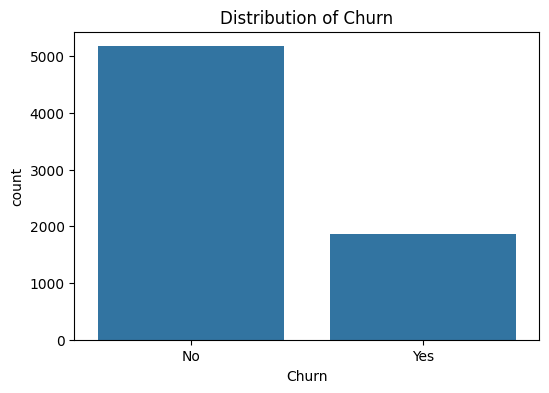

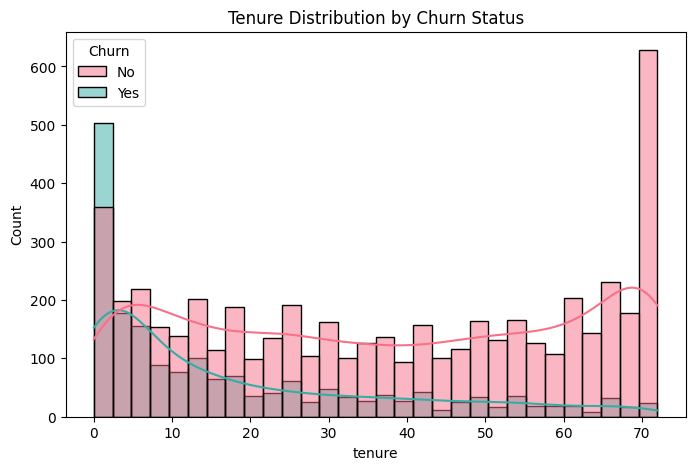

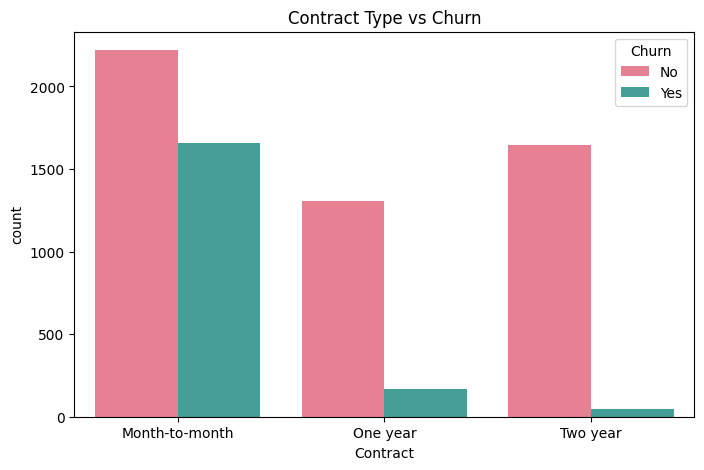

In [ ]:
df = pd.read_csv("C:/Users/RAM PRAHASITH/OneDrive/Desktop/F ML/Lab05-Prahas2001/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

print(df.info())

print("\nData type of 'TotalCharges':", df['TotalCharges'].dtype)

non_numeric_totalcharges = df[~df['TotalCharges'].str.replace('.', '', 1).str.isdigit()]
print("\nNon-numeric 'TotalCharges' entries (if any):")
print(non_numeric_totalcharges[['customerID', 'TotalCharges']])

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

missing_values = df.isnull().sum()
print(missing_values)

totalcharges_missing = df['TotalCharges'].isnull().sum()
print(f"\nNumber of missing values in 'TotalCharges': {totalcharges_missing}")


median_totalcharges = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_totalcharges)


print("\nMissing values after imputing 'TotalCharges':")
print(df.isnull().sum())


plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, bins=30, palette='husl')
plt.title('Tenure Distribution by Churn Status')
plt.show()

# Relationship between categorical feature and churn 
plt.figure(figsize=(8,5))
sns.countplot(x='Contract', hue='Churn', data=df, palette='husl')
plt.title('Contract Type vs Churn')
plt.show()

***Task 2: Feature Engineering***

In [11]:
df['AvgMonthlyCharge'] = df['TotalCharges']/(df['tenure']+1)
df['hasPhoneService'] = df['PhoneService'].map({'Yes':1, 'No':0})
df['hasInternetService'] = df['InternetService'].map({'No':0, 'DSL':1, 'Fiber optic':1})
df['ServiceCount'] = df['hasPhoneService']+df['hasInternetService']

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlyCharge,hasPhoneService,hasInternetService,ServiceCount
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,14.925000,0,1,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,53.985714,1,1,2
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,36.050000,1,1,2
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,40.016304,0,1,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,50.550000,1,1,2


***Task 3: Building the End-to-End Pipeline***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()


numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)])


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

pipeline.fit(X_train, y_train)
print("Pipeline successfully trained! You can now use it for predictions and evaluation.")

Pipeline successfully trained! You can now use it for predictions and evaluation.


In [13]:
pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


***Task 4: Model Selection and Hyperparameter Tuning***

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]}


grid_search = GridSearchCV(
    estimator=pipeline,  
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',  
    n_jobs=-1,
    verbose=2)


grid_search.fit(X_train, y_train)


print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation f1_weighted score:", grid_search.best_score_)


best_model = grid_search.best_estimator_


pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
pipeline_lr.fit(X_train, y_train)


pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
pipeline_gb.fit(X_train, y_train)

Evaluate all models on test data
print("\nLogistic Regression Performance:")
y_pred_lr = pipeline_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

print("\nGradient Boosting Performance:")
y_pred_gb = pipeline_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb))

print("\nTuned Random Forest Performance:")
y_pred_rf = best_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
best_f1 = max(f1_lr, f1_gb, f1_rf)
if best_f1 == f1_lr:
    best_model_name = "Logistic Regression"
    best_pipe = pipeline_lr
elif best_f1 == f1_gb:
    best_model_name = "Gradient Boosting"
    best_pipe = pipeline_gb
else:
    best_model_name = "Tuned Random Forest"
    best_pipe = best_model

print(f"\nBest model based on weighted F1 score: {best_model_name} with score {best_f1:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best cross-validation f1_weighted score: 0.7854899997126334

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.68      0.53      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.67      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


Tuned Random Forest Performance:
  

***Task 5: Handling Class Imbalance***

In [ ]:
pipe_lr_balanced = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))])

# Train the model
pipe_lr_balanced.fit(X_train, y_train)

# Predict on test set
y_pred_balanced = pipe_lr_balanced.predict(X_test)

# Evaluate performance
print("Logistic Regression with class_weight='balanced' Performance:")
print(classification_report(y_test, y_pred_balanced))

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print("Logistic Regression without class weighting Performance:")
print(classification_report(y_test, y_pred))

Logistic Regression with class_weight='balanced' Performance:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.54      0.76      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409

Logistic Regression without class weighting Performance:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.68      0.53      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



***Task 6: Final Evaluation and Interpretation***

Precision: 0.5410
Recall: 0.7594
F1-Score: 0.6318
ROC AUC Score: 0.8472

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.54      0.76      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



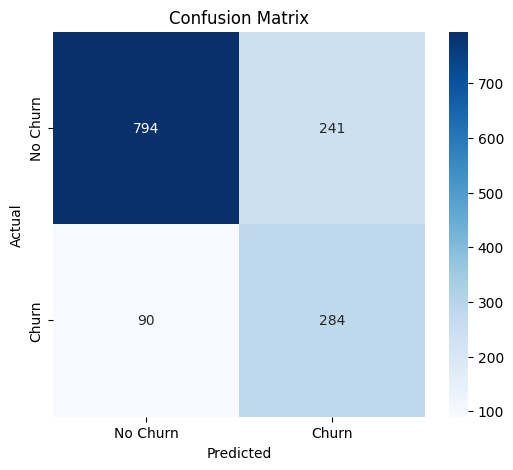

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = pipe_lr_balanced.predict(X_test)
y_prob = pipe_lr_balanced.predict_proba(X_test)[:, 1]

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()